## Машинное обучение, ВМК МГУ

## Практическое задание 2

### Общая информация
Дата выдачи: 9 октября 2019

Максимальная оценка: 10 баллов + 1 бонусный балл

Мягкий дедлайн: 23:59MSK 23 октября (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 30 октября.

### О задании

В этом задании вы:
- Познакомитесь с методом решения задачи регрессии на основе метода ближайших соседей.
- Реализуете алгоритм kNN для задачи регрессии.
- Изучите методы работы с категориальными и текстовыми переменными.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-02-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-02-ivanov.ipynb).

Далее отправьте этот файл на anytask в соответсвующий раздел.

In [241]:
import numpy as np
import pandas as pd
import datetime
import time
import sys
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsRegressor

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования New York City Airbnb Open Data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data#AB_NYC_2019.csv

В данной задаче предлагается предсказать цену на съем квартиры в зависимости от её параметров.

In [242]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [243]:
data.shape

(48895, 16)

In [6]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

id 48895
name 47906
host_id 37457
host_name 11453
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1765
reviews_per_month 938
calculated_host_listings_count 47
availability_365 366


In [5]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Как видите, в данных есть пропуски. Не забудьте обработать их

In [244]:
dt = pd.to_datetime(data.dropna()['last_review'])

-0.016842840099168796


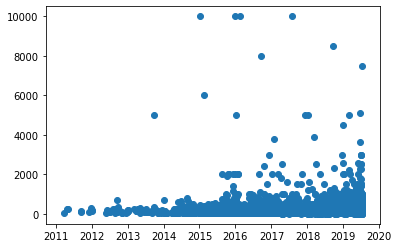

In [245]:
idx = dt.reset_index()['index']
print(np.corrcoef(dt.values.astype(np.int64) / 1e9, data['price'][idx].values)[1, 0])
plt.scatter(dt.values, data['price'][idx])

In [246]:
dt.astype(np.int64).max() / 1e9

1562544000.0

In [247]:
ts = 1562544000

In [248]:
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2019-07-08 00:00:00


In [249]:
data[['name', 'host_name']] = data[['name', 'host_name']].fillna('unknown')
data[['reviews_per_month']] = data[['reviews_per_month']].fillna(data['reviews_per_month'].mean())
data[['last_review']] = data[['last_review']].fillna('2019-07-08') # filling with latest date

Разобъем данные на обучение и контроль.

In [250]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

## Часть 1: Алгоритм kNN в задаче регрессии

<b> 1.1 (1.5 балла) </b>
Реализуйте класс `KNNRegressor`, который используя метод k ближайших соседей решает задачу регрессии. Для решение данной задачи, необходимо найти $N_k$ - k соседей, и после использовать значения их целевых переменных для предсказания:
\begin{align}
y = \frac{1}{k}\sum_{n \in N_k}w_n y_n,
\end{align}

где $w_n$ - вес каждого соседа. 

При этом `KNNRegressor` может работать в 2 режимах:
 - $uniform$ - ближайшие соседи учитываются с одинаковыми весами.
 - $distance$ - вес ближайших соседей зависит от расстояния
 
Сигнатуру методов при желании можно менять.

In [21]:
from typing import Union, Callable, Iterable, Optional
from sklearn.neighbors import NearestNeighbors


class KNNRegressor:
    def __init__(self, n_neighbors: int, metric: Union[str, Callable], mode: str = 'uniform'):
        """
        params:
            n_neighbors: number of neighbors
            metric: metric to use for distance computation
            mode: 'uniform' or 'distance'
            'uniform' - all points in each neighborhood are weighted equally
            'distance' - weight points by the inverse of their distance
        """
        self.__nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
        self.__mode = mode
        self.__n_neighbors = n_neighbors

    def fit(self, X: np.array, y: np.array) -> None:
        """
            X: data
            y: labels
        """
        self.__nn.fit(X)
        self.__labels = y

    def predict(self, X: np.array, n_neighbors: Optional[int] = None) -> np.array:
        """
            X: data
            n_neighbors: number of neighbors
        """
        if self.__mode == 'uniform':
            nearest_labels = self.__labels[self.__nn.kneighbors(X, return_distance=False)]
            return nearest_labels.mean(axis=1)
        else:
            dist, ind = self.__nn.kneighbors(X, return_distance=True)
            inv = np.reciprocal(dist + 1e-5, dtype=np.float64)
            inv /= inv.sum(axis=1)[:, np.newaxis]
            nearest_labels = self.__labels[ind]
            return np.diag(np.dot(nearest_labels, inv.T))

## Часть 2: Категориальные признаки

<b>2.1 (1 балл)</b>
Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на [третьем семинаре](https://github.com/mmp-mmro-team/mmp_mmro_fall_2019/blob/master/lecture-notes/Sem03_knn.pdf). Не забудьте, что KNNRegressor должен уметь работать с этими функциями расстояния. Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In [5]:
class overlap:
    def __call__(self, x, z):
        return (x != z).sum()

class flattened_overlap:
    def fit(self, X_train):
        self.f = []
        self.l = X_train.shape[0]
        for column in X_train.T:
            d = dict(zip(*np.unique(column, return_counts=True)))
            self.f.append(d)
    
    def _f(self, j, x):
        if x in self.f[j].keys():
            return self.f[j][x]
        else:
            return 0
    
    def _p(self, j, x):
        return self._f(j, x) / self.l
    
    def _p_squared(self, j, x):
        return (self._f(j, x) * (self._f(j, x) - 1)) / (self.l * (self.l - 1))
    
    def __call__(self, x, z):
        result = 0
        for i in range(len(x)):
            if x[i] != z[i]:
                result += 1
            else:
                tresh = self._p(i, x[i])
                for q in self.f[i].keys():
                    if self._p(i, q) <= tresh:
                        result += self._p_squared(i, q)
        return result

class log_overlap:
    def fit(self, X_train):
        self.f = []
        self.l = X_train.shape[0]
        for column in X_train.T:
            d = dict(zip(*np.unique(column, return_counts=True)))
            self.f.append(d)
    
    def _f(self, j, x):
        if x in self.f[j].keys():
            return self.f[j][x]
        else:
            return 0
            
    def __call__(self, x, z):
        result = 0
        for i in range(len(x)):
            if x[i] != z[i]:
                result += np.log(self._f(i, x[i]) + 1) * np.log(self._f(i, z[i]) + 1)
        return result

<b>2.2 (1 балл)</b> Найдите все категориальные признаки в данных. Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Качество измеряйте с помощью RMSE.

Какая функция расстояния оказалась лучшей? Почему?

Lets look at number of unique values in each column.

In [6]:
for col_name in data.columns:
    print(col_name, data[col_name].nunique())

id 48895
name 47905
host_id 37457
host_name 11452
neighbourhood_group 5
neighbourhood 221
latitude 19048
longitude 14718
room_type 3
price 674
minimum_nights 109
number_of_reviews 394
last_review 1764
reviews_per_month 937
calculated_host_listings_count 47
availability_365 366


In [7]:
data['neighbourhood_group']

0         Brooklyn
1        Manhattan
2        Manhattan
3         Brooklyn
4        Manhattan
           ...    
48890     Brooklyn
48891     Brooklyn
48892    Manhattan
48893    Manhattan
48894    Manhattan
Name: neighbourhood_group, Length: 48895, dtype: object

In [8]:
data['neighbourhood']

0                Kensington
1                   Midtown
2                    Harlem
3              Clinton Hill
4               East Harlem
                ...        
48890    Bedford-Stuyvesant
48891              Bushwick
48892                Harlem
48893        Hell's Kitchen
48894        Hell's Kitchen
Name: neighbourhood, Length: 48895, dtype: object

In [9]:
data['room_type']

0           Private room
1        Entire home/apt
2           Private room
3        Entire home/apt
4        Entire home/apt
              ...       
48890       Private room
48891       Private room
48892    Entire home/apt
48893        Shared room
48894       Private room
Name: room_type, Length: 48895, dtype: object

As we can see, these column contain some categorical labels. Although last 7 columns contain few unique values, they are continuous. First 3 columns are also useless for model since they are just unique names.

Remark from Telegram:<br>
Мария, [19.10.19 17:37]
Да, остальные (не категориальные)признаки не нужны в этом пункте

In [1]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

NameError: name 'X_train' is not defined

In [34]:
for i in range(3):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(np.concatenate((X_train_cat.iloc[:, i].values, X_test_cat.iloc[:, i].values)))
    X_train_cat.iloc[:, i] = label_encoder.transform(X_train_cat.iloc[:, i])
    X_test_cat.iloc[:, i] = label_encoder.transform(X_test_cat.iloc[:, i])

C:\conda\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\conda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
metric_overlap = overlap()
metric_log_overlap = log_overlap()
metric_flatten_overlap = flattened_overlap()
metric_log_overlap.fit(X_train_cat.values)
metric_flatten_overlap.fit(X_train_cat.values)

### Overlap 

In [18]:
%%time
clf = KNNRegressor(10, metric_overlap, 'distances')
clf.fit(X_train_cat.values, y_train.values.flatten())
res_overlap = clf.predict(X_test_cat.values)

Wall time: 8min 19s


In [153]:
res_overlap

array([145.7, 187.9, 169.9, ..., 526.1, 361.2, 330.3])

RMSE

In [152]:
np.sqrt(((res_overlap - y_test.values.flatten()) ** 2).mean())

217.5072094187037

### Log overlap

In [157]:
%%time
clf = KNNRegressor(10, metric_log_overlap, 'distances')
clf.fit(X_train_cat.values, y_train.values.flatten())
res_log = clf.predict(X_test_cat.values)

Wall time: 37min 45s


In [158]:
res_log

array([145.7, 187.9, 169.9, ..., 526.1, 361.2, 330.3])

In [162]:
(res_log == res_overlap).sum() / len(res_overlap)

0.8044174790374259

80% match with overlap answers

RMSE

In [159]:
np.sqrt(((res_log - y_test.values.flatten()) ** 2).mean())

217.50213804866817

### Flatten overlap

In [13]:
%%time
clf = KNNRegressor(10, metric_flatten_overlap, 'distances')
clf.fit(X_train_cat.values, y_train.values.flatten())
res_flatten = clf.predict(X_test_cat.values)

Wall time: 2h 22min 2s


In [14]:
res_flatten

array([145.7, 187.9, 169.9, ..., 526.1, 361.2, 330.3])

In [19]:
(res_flatten == res_overlap).sum() / len(res_overlap)

0.682186924807417

68% match with overlap answers

RMSE

In [20]:
np.sqrt(((res_flatten - y_test.values.flatten()) ** 2).mean())

217.26930655862319

The best results were shown by a model using flatten overlap metric. It's obvious that overlap is not the best way to calculate distance between categorical features (because is has no information about frequency of feature), but its hard to say why in this specific case flatten overlap works better.

<b>2.3 (1 балл) бонус</b> Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какого удалось достичь уровня качества?

<b>2.4 (2.5 балла)</b> Отойдем ненадолго от задачи регрессии и перейдём к задаче классификации: будем определять, являеться ли квартира дорогой $(target = 1)$ или дешевой $(target = 0)$. Будем считать дорогими квариры, цена которых выше среднего.

In [39]:
data['target'] = (data.price > data.price.mean()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data[['price']],
                                                    test_size=0.3, random_state=241)

Реализуйте счетчики, которые заменят категориальные признаки на вещественные.

А именно, для каждого категориального признака $f_j(x)$ необходимо сделать следующее:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
\begin{align}
counts_j(c) = \sum_{i=1}^l [f_j(x_i) = c]
\end{align}
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
\begin{align}
successes_j(c) = \sum_{i=1}^l[f_j(x_i) = c][y_i = +1].
\end{align}
3. Сглаженное отношение двух предыдущих величин:
\begin{align}
p_j(c) = \frac{successes_j(c) + a}{counts_j(c) + b},
\end{align}

где $a$ и $b$ - априорные счетчики (например, a = 1, b = 2).

In [86]:
def counts_cnt(X_train, X_test):
    d = dict(zip(*np.unique(X_train, return_counts=True)))
    return np.array([d[t] if t in d.keys() else 0 for t in X_test])

def success_cnt(X_train, y, X_test):
    u = X_train[y == 1]
    d = dict(zip(*np.unique(u, return_counts=True)))
    return np.array([d[t] if t in d.keys() else 0 for t in X_test])

def flatten_cnt(X_train, y, X_test, a, b):
    return (success_cnt(X_train, y, X_test) + a) / (counts_cnt(X_train, X_test) + b)

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Достаточно взять $n = 3$.

In [87]:
def kfold(n, n_folds):
    my_range = np.arange(n)
    result = []
    fold_size = int(np.ceil(n / n_folds))
    for k in range(n_folds):
        train_1 = np.arange(0, k * fold_size)
        train_2 = np.arange((k + 1) * fold_size, n)
        val = np.arange(k * fold_size, min((k + 1) * fold_size, n))
        result.append( (np.concatenate((train_1, train_2)), val) )
    return result

def fold_counters(x, fold_num, labels):
    """
    params:
        x: value on categorical feature for N objects
    returns: vector of length N
    """
    result1 = np.zeros(len(x))
    result2 = np.zeros(len(x))
    result3 = np.zeros(len(x))
    folds = kfold(len(x), fold_num)
    for idx_train, idx_test in folds:
        result1[idx_test] = flatten_cnt(x[idx_train], labels[idx_train], x[idx_test], 1, 2)
        result2[idx_test] = counts_cnt(x[idx_train], x[idx_test])
        result3[idx_test] = success_cnt(x[idx_train], labels[idx_train], x[idx_test])
    return result1, result2, result3

Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

### With folding

In [156]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]

In [157]:
# Test
target_train = X_train_cat['target'].values
target_test  = X_test_cat['target'].values

flatten_1 = flatten_cnt(X_train_cat['neighbourhood_group'].values, target_train, X_test_cat['neighbourhood_group'].values, 1, 2)
counts_1 = counts_cnt(X_train_cat['neighbourhood_group'].values, X_test_cat['neighbourhood_group'].values)
success_1 = success_cnt(X_train_cat['neighbourhood_group'].values, target_train, X_test_cat['neighbourhood_group'].values)

X_test_cat['neighbourhood_group_f'] = flatten_1
X_test_cat['neighbourhood_group_c'] = counts_1
X_test_cat['neighbourhood_group_s'] = success_1

flatten_2 = flatten_cnt(X_train_cat['neighbourhood'].values, target_train, X_test_cat['neighbourhood'].values, 1, 2)
counts_2 = counts_cnt(X_train_cat['neighbourhood'].values, X_test_cat['neighbourhood'].values)
success_2 = success_cnt(X_train_cat['neighbourhood'].values, target_train, X_test_cat['neighbourhood'].values)

X_test_cat['neighbourhood_f'] = flatten_2
X_test_cat['neighbourhood_c'] = counts_2
X_test_cat['neighbourhood_s'] = success_2

flatten_3 = flatten_cnt(X_train_cat['room_type'].values, target_train, X_test_cat['room_type'].values, 1, 2)
counts_3 = counts_cnt(X_train_cat['room_type'].values, X_test_cat['room_type'].values)
success_3 = success_cnt(X_train_cat['room_type'].values, target_train, X_test_cat['room_type'].values)

X_test_cat['room_type_f'] = flatten_3
X_test_cat['room_type_c'] = counts_3
X_test_cat['room_type_s'] = success_3
    
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)

# Train
t_flatten_1, t_counts_1, t_success_1 = fold_counters(X_train_cat['neighbourhood_group'].values, 3, target_train)
t_flatten_2, t_counts_2, t_success_2 = fold_counters(X_train_cat['neighbourhood'].values, 3, target_train)
t_flatten_3, t_counts_3, t_success_3 = fold_counters(X_train_cat['room_type'].values, 3, target_train)

X_train_cat['neighbourhood_group_f'] = t_flatten_1
X_train_cat['neighbourhood_group_c'] = t_counts_1
X_train_cat['neighbourhood_group_s'] = t_success_1

X_train_cat['neighbourhood_f'] = t_flatten_2
X_train_cat['neighbourhood_c'] = t_counts_2
X_train_cat['neighbourhood_s'] = t_success_2

X_train_cat['room_type_f'] = t_flatten_3
X_train_cat['room_type_c'] = t_counts_3
X_train_cat['room_type_s'] = t_success_3

X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)

C:\conda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\conda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\conda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

### ROC-AUC scores with folding

In [159]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(X_train_cat)
X_train_cat = nrm.transform(X_train_cat)
X_test_cat = nrm.transform(X_test_cat)

best_k = -1
max_score = -1
for k in k_param:
    clf = KNeighborsClassifier(k, metric='euclidean', weights='distance')
    clf.fit(X_train_cat, target_train)
    pred = clf.predict_proba(X_test_cat)[:, 1]
    score = roc_auc_score(target_test, pred)
    #print(f'k: {k} | ROC-AUC: {score}')
    if score > max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, ROC-AUC = {max_score}')

best results: k = 91, ROC-AUC = 0.8668711579869955


### Without folding

In [160]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type', 'target']]

In [161]:
# Test
target_train = X_train_cat['target'].values
target_test  = X_test_cat['target'].values

flatten_1 = flatten_cnt(X_train_cat['neighbourhood_group'].values, target_train, X_test_cat['neighbourhood_group'].values, 1, 2)
counts_1 = counts_cnt(X_train_cat['neighbourhood_group'].values, X_test_cat['neighbourhood_group'].values)
success_1 = success_cnt(X_train_cat['neighbourhood_group'].values, target_train, X_test_cat['neighbourhood_group'].values)

X_test_cat['neighbourhood_group_f'] = flatten_1
X_test_cat['neighbourhood_group_c'] = counts_1
X_test_cat['neighbourhood_group_s'] = success_1

flatten_2 = flatten_cnt(X_train_cat['neighbourhood'].values, target_train, X_test_cat['neighbourhood'].values, 1, 2)
counts_2 = counts_cnt(X_train_cat['neighbourhood'].values, X_test_cat['neighbourhood'].values)
success_2 = success_cnt(X_train_cat['neighbourhood'].values, target_train, X_test_cat['neighbourhood'].values)

X_test_cat['neighbourhood_f'] = flatten_2
X_test_cat['neighbourhood_c'] = counts_2
X_test_cat['neighbourhood_s'] = success_2

flatten_3 = flatten_cnt(X_train_cat['room_type'].values, target_train, X_test_cat['room_type'].values, 1, 2)
counts_3 = counts_cnt(X_train_cat['room_type'].values, X_test_cat['room_type'].values)
success_3 = success_cnt(X_train_cat['room_type'].values, target_train, X_test_cat['room_type'].values)

X_test_cat['room_type_f'] = flatten_3
X_test_cat['room_type_c'] = counts_3
X_test_cat['room_type_s'] = success_3
    
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)

# Train
t_flatten_1 = flatten_cnt(X_train_cat['neighbourhood_group'].values, target_train, X_train_cat['neighbourhood_group'].values, 1, 2)
t_counts_1 = counts_cnt(X_train_cat['neighbourhood_group'].values, X_train_cat['neighbourhood_group'].values)
t_success_1 = success_cnt(X_train_cat['neighbourhood_group'].values, target_train, X_train_cat['neighbourhood_group'].values)

X_train_cat['neighbourhood_group_f'] = t_flatten_1
X_train_cat['neighbourhood_group_c'] = t_counts_1
X_train_cat['neighbourhood_group_s'] = t_success_1

t_flatten_2 = flatten_cnt(X_train_cat['neighbourhood'].values, target_train, X_train_cat['neighbourhood'].values, 1, 2)
t_counts_2 = counts_cnt(X_train_cat['neighbourhood'].values, X_train_cat['neighbourhood'].values)
t_success_2 = success_cnt(X_train_cat['neighbourhood'].values, target_train, X_train_cat['neighbourhood'].values)

X_train_cat['neighbourhood_f'] = t_flatten_2
X_train_cat['neighbourhood_c'] = t_counts_2
X_train_cat['neighbourhood_s'] = t_success_2

t_flatten_3 = flatten_cnt(X_train_cat['room_type'].values, target_train, X_train_cat['room_type'].values, 1, 2)
t_counts_3 = counts_cnt(X_train_cat['room_type'].values, X_train_cat['room_type'].values)
t_success_3 = success_cnt(X_train_cat['room_type'].values, target_train, X_train_cat['room_type'].values)

X_train_cat['room_type_f'] = t_flatten_3
X_train_cat['room_type_c'] = t_counts_3
X_train_cat['room_type_s'] = t_success_3
    
X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'target'], inplace=True)

C:\conda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\conda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\conda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

### ROC-AUC scores without folding

In [162]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(X_train_cat)
X_train_cat = nrm.transform(X_train_cat)
X_test_cat = nrm.transform(X_test_cat)

best_k = -1
max_score = -1
for k in k_param:
    clf = KNeighborsClassifier(k, metric='euclidean', weights='distance')
    clf.fit(X_train_cat, target_train)
    pred = clf.predict_proba(X_test_cat)[:, 1]
    score = roc_auc_score(target_test, pred)
    #print(f'k: {k} | ROC-AUC: {score}')
    if score > max_score:
        best_k = k
        max_score = score
print(f'best results: k = {best_k}, ROC-AUC = {max_score}')

best results: k = 96, ROC-AUC = 0.8633880894685682


Folding increases score a bit...

In [164]:
0.8668711579869955 - 0.8633880894685682

0.00348306851842739

<b>2.5 (1 балл)</b> Вернемся к задаче регрессии. Утверждается, что для задачи регрессии можно также сделать преобразование категориальных признаков в действительные числа. Для этого достаточно для каждого значения признака $f_j$ вычислить:
\begin{align}
p_j(c) = g(T_i | f_j(x_i) = c),
\end{align}

где $T_i$ - значения целевой переменной объекта $x_i$. Функция $g$ - среднее (mean) или среднеквадратичное отклонение (std).

Закодируйте категориальные признаки обоими способами и найдите значение RMSE. Используйте евклидову метрику для поиска ближайших соседей. Для какой функции $g$ значение RMSE лучше? Почему?

### Mean

In [17]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

In [18]:
X_train_cat['cost'] = y_train

C:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
nei_grp_mean = X_train_cat[['neighbourhood_group', 'cost']].groupby('neighbourhood_group').agg('mean')['cost'].to_dict()
nei_mean = X_train_cat[['neighbourhood', 'cost']].groupby('neighbourhood').agg('mean')['cost'].to_dict()
rt_mean = X_train_cat[['room_type', 'cost']].groupby('room_type').agg('mean')['cost'].to_dict()

nei_grp_std = X_train_cat[['neighbourhood_group', 'cost']].groupby('neighbourhood_group').agg('std')['cost'].to_dict()
nei_std = X_train_cat[['neighbourhood', 'cost']].groupby('neighbourhood').agg('std')['cost'].to_dict()
rt_std = X_train_cat[['room_type', 'cost']].groupby('room_type').agg('std')['cost'].to_dict()

In [20]:
def encode_ft(name, how, X):
    xxx = X_train_cat[[name, 'cost']].groupby(name).agg(how)['cost'].to_dict()
    res = np.array([xxx[t] if t in xxx.keys() else 0 for t in X[name].values])
    return res

In [21]:
X_test_cat['n_g_m'] = encode_ft('neighbourhood_group', 'mean', X_test_cat)
X_test_cat['n_m'] = encode_ft('neighbourhood', 'mean', X_test_cat)
X_test_cat['rt_m'] = encode_ft('room_type', 'mean', X_test_cat)

C:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\conda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [22]:
X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)

C:\conda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
X_train_cat['n_g_m'] = encode_ft('neighbourhood_group', 'mean', X_train_cat)
X_train_cat['n_m'] = encode_ft('neighbourhood', 'mean', X_train_cat)
X_train_cat['rt_m'] = encode_ft('room_type', 'mean', X_train_cat)

C:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\conda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [24]:
X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'cost'], inplace=True)

In [25]:
X_train_cat

,n_g_m,n_m,rt_m
39319,125.588152,89.544000,90.525220
22796,197.712695,220.979339,212.716015
26190,100.009070,84.309963,90.525220
8161,197.712695,184.035948,212.716015
32473,197.712695,185.774395,212.716015
...,...,...,...
41432,197.712695,229.417822,212.716015
8690,197.712695,251.039801,90.525220
144,125.588152,107.822838,212.716015
10987,125.588152,109.569343,212.716015


In [26]:
X_test_cat

,n_g_m,n_m,rt_m
2850,125.588152,149.566406,212.716015
44256,197.712695,251.039801,212.716015
6636,125.588152,144.875182,212.716015
332,125.588152,211.490385,212.716015
43143,197.712695,208.630137,212.716015
...,...,...,...
3880,197.712695,136.170543,212.716015
48120,197.712695,290.953307,212.716015
456,197.712695,185.774395,212.716015
42059,125.588152,151.645833,90.525220


In [31]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(X_train_cat)
X_train_cat = nrm.transform(X_train_cat)
X_test_cat = nrm.transform(X_test_cat)

best_k = -1
max_score = 10000

for k in k_param:
    mdl = KNNRegressor(k, metric='euclidean', mode='distance')
    mdl.fit(X_train_cat, y_train.values.flatten())
    pred = mdl.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    
    if score < max_score:
        best_k = k
        max_score = score
print(f'best k: {best_k}, best RMSE: {max_score}')

best k: 81, best RMSE: 207.55551982688326


### Std

In [32]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

In [33]:
X_train_cat['cost'] = y_train

C:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
X_test_cat['n_g_s'] = encode_ft('neighbourhood_group', 'std', X_test_cat)
X_test_cat['n_s'] = encode_ft('neighbourhood', 'std', X_test_cat)
X_test_cat['rt_s'] = encode_ft('room_type', 'std', X_test_cat)

X_test_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)

X_train_cat['n_g_s'] = encode_ft('neighbourhood_group', 'std', X_train_cat)
X_train_cat['n_s'] = encode_ft('neighbourhood', 'std', X_train_cat)
X_train_cat['rt_s'] = encode_ft('room_type', 'std', X_train_cat)

X_train_cat.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type', 'cost'], inplace=True)

C:\conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\conda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [35]:
k_param = np.arange(1, 100, 5)

X_train_cat.fillna(0, inplace=True)
X_test_cat.fillna(0, inplace=True)

nrm = Normalizer()
nrm.fit(X_train_cat)
X_train_cat = nrm.transform(X_train_cat)
X_test_cat = nrm.transform(X_test_cat)

best_k = -1
max_score = 10000

for k in k_param:
    mdl = KNNRegressor(k, mode='distance', metric='euclidean')
    mdl.fit(X_train_cat, y_train.values.flatten())
    pred = mdl.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    
    if score < max_score:
        best_k = k
        max_score = score
print(f'best k: {best_k}, best RMSE: {max_score}')

C:\conda\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


best k: 96, best RMSE: 208.2473800984568


Mean version works a bit better. Its hard to name a reason of it because difference is small enough, maybe the distribution of means is a bit more suitable for distinguishing between clusters of data in our specific case.

## Часть 3: Текстовые признаки

<b>3.1 (2 балла)</b> Перейдем от категориальным признаков к текстовым. Рассмотрим 2 способа преобразования текста в действительные числа:
- Мешок слов (Bag of Words)
- TF-IDF

[Здесь](https://scikit-learn.org/stable/modules/feature_extraction.html) вы можете прочитать про их применение в Питоне.

Сравните оба способа на задаче регресси. Какую лучше метрику использовать: евклидову или косинусную меру? Постройте графики зависимости качества решения задачи от способа преобразования, метрики и количества соседей. Мера качества - RMSE.

Объясните полученные результаты.

Перед преобразованием не забудьте уменьшить размер словаря. Например, это можно сделать за счет приведения всех слов к одному регистру и удаления [стопслов](https://en.wikipedia.org/wiki/Stop_words) (артиклей, предлогов, союзов).

In [145]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

In [9]:
X_train_cat

,neighbourhood_group,neighbourhood,room_type
39319,Brooklyn,Kensington,Private room
22796,Manhattan,Gramercy,Entire home/apt
26190,Queens,Sunnyside,Private room
8161,Manhattan,Upper East Side,Entire home/apt
32473,Manhattan,East Village,Entire home/apt
...,...,...,...
41432,Manhattan,Financial District,Entire home/apt
8690,Manhattan,Chelsea,Private room
144,Brooklyn,Bedford-Stuyvesant,Entire home/apt
10987,Brooklyn,Sunset Park,Entire home/apt


### TF-IDF

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer

f1 = TfidfVectorizer(stop_words='english')
f2 = TfidfVectorizer(stop_words='english')
f3 = TfidfVectorizer(stop_words='english')

train_ng = f1.fit_transform(np.array(X_train_cat['neighbourhood_group'])).toarray()
train_n = f2.fit_transform(np.array(X_train_cat['neighbourhood'])).toarray()
train_rt = f3.fit_transform(np.array(X_train_cat['room_type'])).toarray()

tf_train = np.concatenate((train_ng, train_n, train_rt), axis=1)

test_ng = f1.transform(np.array(X_test_cat['neighbourhood_group'])).toarray()
test_n = f2.transform(np.array(X_test_cat['neighbourhood'])).toarray()
test_rt = f3.transform(np.array(X_test_cat['room_type'])).toarray()

tf_test = np.concatenate((test_ng, test_n, test_rt), axis=1)

print(tf_train.shape, tf_test.shape)

(34226, 249) (14669, 249)


In [48]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(tf_train)
X_train_cat = nrm.transform(tf_train)
X_test_cat = nrm.transform(tf_test)

best_k = -1
max_score = 10000

scores = np.arange(1, 100, 5)

for i, k in enumerate(k_param):
    mdl = KNNRegressor(k, mode='uniform', metric='euclidean')
    mdl.fit(X_train_cat, y_train.values.flatten())
    pred = mdl.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores[i] = score
    if score < max_score:
        best_k = k
        max_score = score
    print(k, score)
print(f'best k: {best_k}, best RMSE: {max_score}')

1 253.43139226272905
6 217.03946246586725
11 213.8020652418443
16 211.13286972785076
21 210.6285480709012
26 208.92586494313952
31 208.4003338464445
36 208.0085290217739
41 207.88632215539613
46 207.4522300368012
51 207.42855366515064
56 207.3082896220935
61 207.17513625047187
66 207.1133993376432
71 207.17170969831326
76 207.28739026295094
81 207.18040805860312
86 207.02330093873246
91 207.0458879127179
96 206.9809376985742
best k: 96, best RMSE: 206.9809376985742


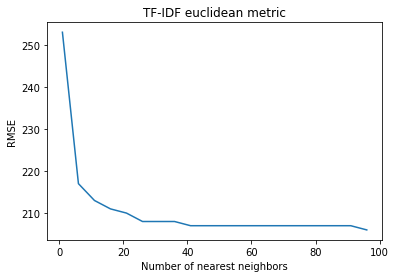

In [49]:
plt.title('TF-IDF euclidean metric')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('RMSE')
plt.plot(k_param, scores)

Here spaghetti code begins... You need to execute some of previous cells before executing next one. But i believe this is not important in this assignment.

In [53]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(tf_train)
X_train_cat = nrm.transform(tf_train)
X_test_cat = nrm.transform(tf_test)

best_k = -1
max_score = 10000

scores_c = np.arange(1, 100, 5)

for i, k in enumerate(k_param):
    mdl = KNNRegressor(k, mode='uniform', metric='cosine')
    mdl.fit(X_train_cat, y_train.values.flatten())
    pred = mdl.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores_c[i] = score
    if score < max_score:
        best_k = k
        max_score = score
    print(k, score)
print(f'best k: {best_k}, best RMSE: {max_score}')

1 257.03319247829694
6 275.73458514786245
11 231.21301532201696
16 218.6559609696387
21 213.27269377641483
26 214.04219381179257
31 212.03300487130164
36 212.19724651683015
41 210.7896623291365
46 210.47298322575693
51 210.24122272133283
56 209.56929143078113
61 209.08165731024727
66 208.77160456702984
71 208.6716342707663
76 208.3336660704998
81 208.04415234891445
86 207.81944343735867
91 207.73104537830633
96 207.4517232747727
best k: 96, best RMSE: 207.4517232747727


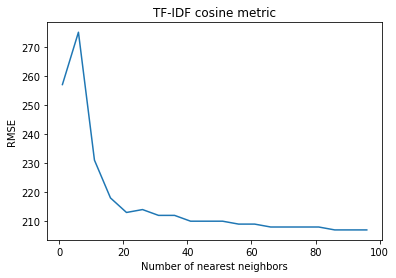

In [54]:
plt.title('TF-IDF cosine metric')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('RMSE')
plt.plot(k_param, scores_c)

### Bag of words

In [18]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

f1 = CountVectorizer(stop_words='english')
f2 = CountVectorizer(stop_words='english')
f3 = CountVectorizer(stop_words='english')

train_ng = f1.fit_transform(np.array(X_train_cat['neighbourhood_group'])).toarray()
train_n = f2.fit_transform(np.array(X_train_cat['neighbourhood'])).toarray()
train_rt = f3.fit_transform(np.array(X_train_cat['room_type'])).toarray()

tf_train = np.concatenate((train_ng, train_n, train_rt), axis=1)

test_ng = f1.transform(np.array(X_test_cat['neighbourhood_group'])).toarray()
test_n = f2.transform(np.array(X_test_cat['neighbourhood'])).toarray()
test_rt = f3.transform(np.array(X_test_cat['room_type'])).toarray()

tf_test = np.concatenate((test_ng, test_n, test_rt), axis=1)

print(tf_train.shape, tf_test.shape)

(34226, 249) (14669, 249)


In [8]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(tf_train)
X_train_cat = nrm.transform(tf_train)
X_test_cat = nrm.transform(tf_test)

best_k = -1
max_score = 10000

scores = np.arange(1, 100, 5)

for i, k in enumerate(k_param):
    mdl = KNNRegressor(k, mode='uniform', metric='euclidean')
    mdl.fit(X_train_cat, y_train.values.flatten())
    pred = mdl.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores[i] = score
    if score < max_score:
        best_k = k
        max_score = score
    print(k, score)
print(f'best k: {best_k}, best RMSE: {max_score}')

1 226.54946607027443
6 209.9300703720499
11 208.8543919401288
16 208.51631029542406
21 207.4676316052715
26 207.61976898029076
31 207.63435836164493
36 207.14022257111395
41 207.3717070077764
46 206.98283536141014
51 206.80982510065945
56 206.8552409497287
61 206.77267868081958
66 206.7264203055284
71 206.68102949364328
76 206.6956511335232
81 206.65913935774813
86 206.7776256615504
91 206.6366788036051
96 206.769987745687
best k: 91, best RMSE: 206.6366788036051


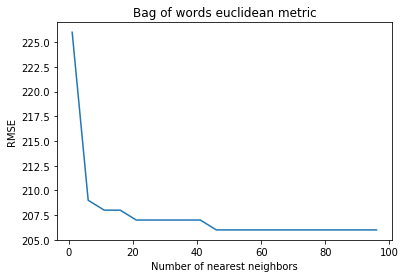

In [13]:
plt.title('Bag of words euclidean metric')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('RMSE')
plt.plot(k_param, scores)

In [13]:
k_param = np.arange(1, 100, 5)

nrm = Normalizer()
nrm.fit(tf_train)
X_train_cat = nrm.transform(tf_train)
X_test_cat = nrm.transform(tf_test)

best_k = -1
max_score = 10000

scores_c = np.arange(1, 100, 5)

for i, k in enumerate(k_param):
    mdl = KNNRegressor(k, mode='uniform', metric='cosine')
    mdl.fit(X_train_cat, y_train.values.flatten())
    pred = mdl.predict(X_test_cat)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores_c[i] = score
    if score < max_score:
        best_k = k
        max_score = score
    print(k, score)
print(f'best k: {best_k}, best RMSE: {max_score}')

1 256.9968521794218
6 268.69779869845877
11 229.76431124649753
16 219.29457549304752
21 214.7571548128119
26 213.61597832597778
31 211.41795407247264
36 211.0017829901303
41 210.03875783293591
46 209.99583282514894
51 209.40199942570834
56 209.10381975258795
61 209.53238182210845
66 208.94915595771033
71 208.54605174469302
76 208.5932775639098
81 208.2637635576019
86 208.03068872531617
91 208.1159483514796
96 207.8651213235757
best k: 96, best RMSE: 207.8651213235757


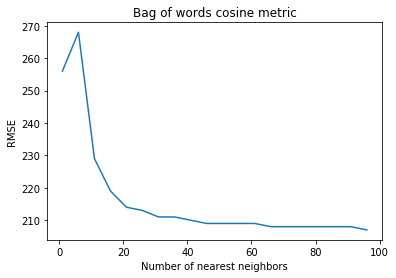

In [15]:
plt.title('Bag of words cosine metric')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('RMSE')
plt.plot(k_param, scores_c)

<center><b>Summary</b> </center>

| Method | Metric | Best k | Best RMSE |
| --- | --- | --- | --- |
| TF-IDF | Euclidean | 96 | 206.98 |
| TF-IDF | Cosine | 96 | 207.45 |
| Bag of words | Euclidean | 91 | 206.63 |
| Bag of words | Cosine | 96 | 207.86 |

The best result was obtained using bag of words approach with euclidean distance and k=91. As we can see from the graphs, with an increase in the number of nearest neighbors, quality first improves, and then goes to a plateau. It is also interesting that when using the cosine metric, the RMSE quality graph has an extremum at small number of neighbors.

<b>3.2 (1 балл)</b> Используя все доступные признаки, решите задачу регрессии. Для категориальных и текстовых признаков выберите лучшие преобразования. Повлияло ли добавление количественного признака на метрику качества?

I selected the best features to fit our model. Features 'number_of_reviews', 'availability_365' and 'last_review' make quality worse. Maybe they can be preprocessed in some specific way to make an improvement, but without it model works a bit worse with them.

In [261]:
train = X_train.iloc[:, 4:]
train.drop(columns=['number_of_reviews', 'availability_365', 'last_review', 'neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)

In [262]:
train.head()

,latitude,longitude,minimum_nights,reviews_per_month,calculated_host_listings_count
39319,40.63628,-73.96970,2,3.670000,3
22796,40.73401,-73.98140,2,0.580000,1
26190,40.74722,-73.91860,2,0.910000,4
8161,40.77357,-73.95193,1,1.373221,1
32473,40.72714,-73.98215,2,2.740000,1


In [263]:
X_train_cat = X_train[['neighbourhood_group', 'neighbourhood', 'room_type']]
X_test_cat = X_test[['neighbourhood_group', 'neighbourhood', 'room_type']]

In [264]:
from sklearn.feature_extraction.text import CountVectorizer

f1 = CountVectorizer(stop_words='english')
f2 = CountVectorizer(stop_words='english')
f3 = CountVectorizer(stop_words='english')

train_ng = f1.fit_transform(np.array(X_train_cat['neighbourhood_group'])).toarray()
train_n = f2.fit_transform(np.array(X_train_cat['neighbourhood'])).toarray()
train_rt = f3.fit_transform(np.array(X_train_cat['room_type'])).toarray()

tf_train = np.concatenate((train_ng, train_n, train_rt), axis=1)

test_ng = f1.transform(np.array(X_test_cat['neighbourhood_group'])).toarray()
test_n = f2.transform(np.array(X_test_cat['neighbourhood'])).toarray()
test_rt = f3.transform(np.array(X_test_cat['room_type'])).toarray()

tf_test = np.concatenate((test_ng, test_n, test_rt), axis=1)

print(tf_train.shape, tf_test.shape)

(34226, 249) (14669, 249)


In [265]:
resulting_train = np.concatenate((train.values, tf_train), axis=1)

In [266]:
test = X_test.iloc[:, 4:]
test.drop(columns=['number_of_reviews', 'availability_365', 'last_review', 'neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
test.head()

,latitude,longitude,minimum_nights,reviews_per_month,calculated_host_listings_count
2850,40.72570,-73.94181,30,0.120000,52
44256,40.74269,-73.99911,30,1.373221,232
6636,40.71349,-73.96290,5,0.470000,1
332,40.69441,-73.99771,3,0.850000,2
43143,40.78232,-73.97575,30,0.420000,1


In [267]:
resulting_test = np.concatenate((test.values, tf_test), axis=1)

In [268]:
final_test.shape

(14669, 254)

In [271]:
final_test.shape

(14669, 254)

In [272]:
nrm = Normalizer()
nrm.fit(resulting_train)
final_train = nrm.transform(resulting_train)
final_test = nrm.transform(resulting_test)

scores = np.arange(1, 100, 5)

for i, k in enumerate(scores):
    mdl = KNNRegressor(k, mode='uniform', metric='euclidean')
    mdl.fit(final_train, y_train.values.flatten())
    pred = mdl.predict(final_test)
    score = np.sqrt(((pred - y_test.values.flatten()) ** 2).mean())
    scores[i] = score
    print(k, score)

1 262.62923784750905
6 221.8033948575586
11 211.37849962403936
16 208.09485683912044
21 206.30366790438444
26 205.1571319053561
31 205.54743652671345
36 205.71591207611252
41 205.7520577766319
46 204.59045355932784
51 204.79679962917436
56 204.77896160784084
61 205.01332993985224
66 205.17577785691572
71 205.24918102986484
76 205.62221539730416
81 205.56570662371735
86 205.59060455682004
91 205.76664186966158
96 205.88412342137582


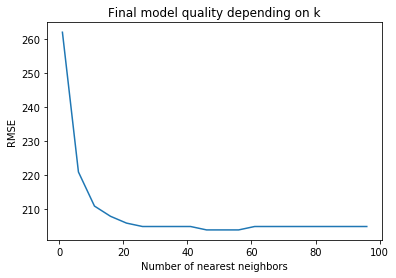

In [279]:
plt.title('Final model quality depending on k')
plt.xlabel('Number of nearest neighbors')
plt.ylabel('RMSE')
plt.plot(k_param, scores)

As we can see, optimal value of k is 46, that corresponds to RMSE = 204.59. We intend to conclude that adding a numerical features actually improves the model.

## Часть 4: Выводы


In this notebook we examined some ways to work with categorical data. Thus after carrying out a comparative description and analysis, it became possible to arrive at the following conclusions:<br>
<ul>
<li>1) It is not so easy to make a comprehensive inference why one method works better than another.
<li>2) It is worth trying several different methods for processing categorical data (especially in text form).
</ul>